# Case Study
## By Sharda Sinha

### Importing all libraries

In [28]:
"""
importing all libraries
"""
import pandas as pd
import nltk
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.stem.snowball import SnowballStemmer

#import spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt

### Code to Generate Word Cloud

In [3]:
def gen_word_cloud(filepath, column):
    """
    Takes file path and relevant column name as input and generates
    word cloud and returns reverse sorted word tokens with associated
    frequency.
    """
    data_df= pd.read_csv(full_path)
    
    corpus_text = data_df[column].str.lower().tolist()
    makeitastring = " ".join(map(str, corpus_text))
    
    STOPWORDS = nltk.corpus.stopwords.words('english')
    #print STOPWORDS
    wordcloud = WordCloud(width = 1000, height = 500, stopwords=set(STOPWORDS))
    wordcloud.generate(makeitastring)
    word_freq = wordcloud.process_text(makeitastring)
    word_freq= sorted(word_freq.items(), key = lambda x: x[1], reverse= True)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return word_freq

### Code for LDA

In [4]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" %(topic_idx))
        print (" ".join([feature_names[i]
            for i in topic.argsort()[:-no_top_words - 1:-1]]))

    
def identify_topics_lda_sklearn(filepath, column):
    """
    Takes file path and relevant column name as input and identifies topic for 
    each document.
    """
    #parameters for Count Vectorizer
    no_features= 1000
    STOPWORDS = nltk.corpus.stopwords.words('english')
    
    # read data from path and extract corpus as iterable 
    data_df= pd.read_csv(full_path)    
    corpus_text = data_df[column].str.lower().tolist()
    
    
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=STOPWORDS)
    tf = tf_vectorizer.fit_transform(corpus_text)
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    #parametere for LDA
    no_topics= 5
    
    #Run LDA
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    no_top_words= 10
    display_topics(lda, tf_feature_names, no_top_words)
    

def sent_to_words(sentences):
    """
    Function to tokenize sentences given an iterable
    """
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    """
    Function to remove stopwords given an iterable
    """
    STOPWORDS = nltk.corpus.stopwords.words('english')
    return [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]


def make_bigrams(texts, bigram_mod):
    """
    Function to generate bigrams given an iterable
    """
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod, trigram_mod):
    """
    Function to generate trigrams given an iterable
    """
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(nlp, texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def text_preprocess_lda_gensim(filepath, column):
    """
    Takes file path and relevant column name as input and returns text prepared 
    (bow) as input for LDA.
    """
    # read data from path and extract corpus as iterable  
    data_df= pd.read_csv(full_path)
    corpus_text = data_df[column].str.lower().tolist()
    
    #tokenizing the sentences
    tokenized_text = list(sent_to_words(corpus_text))
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(tokenized_text, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[tokenized_text], threshold=1) 
    
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    #remove stopwords
    text_nostop= remove_stopwords(tokenized_text)
#    print (text_nostop[0])
     
    #create bigrams
    text_with_bigrams= make_bigrams(text_nostop, bigram_mod )
    
    
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#    python -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    # Do lemmatization keeping only noun, adj, vb, adv
    text_lemmatized = lemmatization(nlp, text_with_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#    print(text_lemmatized[:1])
    
    #create a Gensim dictionary from the processed text
    dictionary = corpora.Dictionary(text_lemmatized)
    
    #Creating corpus for training LDA model
    texts = text_lemmatized
    
    #convert the dictionary to a bag of words corpus for reference
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return text_lemmatized, corpus, dictionary

    
def identify_topics_lda_gensim(corpus, num_topics):
    """
    Takes processed text as input and identifies topic for 
    each document.
    """
            
    
    #Build LDA model
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, 
                            id2word=dictionary, 
                            random_state=100,
                            update_every=1,
                            chunksize=100,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)
    
    perplexity= lda.log_perplexity(corpus)
    
    return lda, perplexity



### Generate Word Cloud

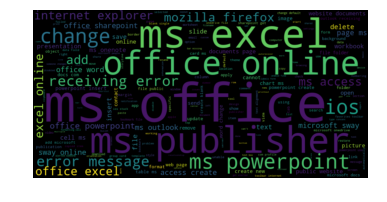

In [5]:
INPUT_PATH=  "D:\\Personal\\Interviews\\Racetrack\\"
FILE_NAME= "issue_resolution.csv"
full_path= INPUT_PATH + FILE_NAME

word_freq= gen_word_cloud(full_path, "ISSUE")

### Implement LDA

In [6]:
#identify_topics_lda_sklearn(full_path, "ISSUE")
text_lemmatized, corpus_for_lda, dictionary= text_preprocess_lda_gensim(full_path, "ISSUE")
lda_model, perplexity= identify_topics_lda_gensim(corpus_for_lda,5)

# Print the Keyword in the topics
print(lda_model.print_topics())


# Compute Perplexity
print('\nPerplexity: ', perplexity)  # a measure of how good the model is. lower the better.


    

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Ana

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

[(0, '0.051*"word" + 0.047*"page" + 0.034*"change" + 0.031*"show" + 0.025*"firefox" + 0.024*"mozilla" + 0.023*"remove" + 0.019*"onenote" + 0.019*"share" + 0.017*"margin"'), (1, '0.082*"microsoft" + 0.069*"ms" + 0.058*"message" + 0.056*"error" + 0.050*"receive" + 0.040*"sway" + 0.029*"outlook" + 0.019*"document" + 0.018*"can" + 0.018*"not"'), (2, '0.147*"office" + 0.110*"online" + 0.097*"ms" + 0.044*"file" + 0.038*"add" + 0.030*"text" + 0.028*"change" + 0.024*"delete" + 0.022*"sharepoint" + 0.018*"page"'), (3, '0.157*"ms" + 0.125*"publisher" + 0.096*"insert" + 0.090*"image" + 0.089*"picture" + 0.086*"search" + 0.084*"bing" + 0.024*"excel" + 0.015*"create" + 0.008*"access"'), (4, '0.110*"ms" + 0.097*"powerpoint" + 0.032*"new" + 0.031*"slide" + 0.030*"presentation" + 0.028*"use" + 0.020*"section" + 0.020*"open" + 0.017*"unable" + 0.016*"select"')]

Perplexity:  -5.70453880441104


### Visualize LDA topics

In [7]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_for_lda, dictionary)
vis

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.329644 -0.011671       1        1  28.940327
2     -0.054858  0.243458       2        1  27.275545
1     -0.066522 -0.193017       3        1  17.743053
0     -0.160274 -0.022288       4        1  13.752034
4     -0.047990 -0.016482       5        1  12.289049, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
315   Default  136.000000        office  136.000000  30.0000  30.0000
527   Default  123.000000     publisher  123.000000  29.0000  29.0000
272   Default  102.000000        online  102.000000  28.0000  28.0000
240   Default   94.000000        insert   94.000000  27.0000  27.0000
268   Default   88.000000         image   88.000000  26.0000  26.0000
269   Default   87.000000       picture   87.000000  25.0000  25.0000
30    Default   84.000000        search   84.000000  24.0000  24.0000
267   Default   82.000000          bing   82.000000  23.0000  23.0000
278   Default   50.000000     microsoft   50.000000  22.0000  22.0000
361   Default   61.000000    powerpoint   61.000000  21.0000  21.0000
35    Default   35.000000       message   35.000000  20.0000  20.0000
34    Default   34.000000         error   34.000000  19.0000  19.0000
37    Default   30.000000       receive   30.000000  18.0000  18.0000
47    Default   41.000000          file   41.000000  17.0000  17.0000
170   Default   24.000000          word   24.000000  16.0000  16.0000
2     Default   39.000000          page   39.000000  15.0000  15.0000
208   Default  336.000000            ms  336.000000  14.0000  14.0000
43    Default   35.000000           add   35.000000  13.0000  13.0000
412   Default   24.000000          sway   24.000000  12.0000  12.0000
27    Default   28.000000          text   28.000000  11.0000  11.0000
41    Default   14.000000           new   14.000000  10.0000  10.0000
7     Default   50.000000        change   50.000000   9.0000   9.0000
179   Default   14.000000          show   14.000000   8.0000   8.0000
109   Default   13.000000         slide   13.000000   7.0000   7.0000
362   Default   13.000000  presentation   13.000000   6.0000   6.0000
467   Default   30.000000       outlook   30.000000   5.0000   5.0000
53    Default   23.000000        delete   23.000000   4.0000   4.0000
22    Default   15.000000           use   15.000000   3.0000   3.0000
176   Default   12.000000       firefox   12.000000   2.0000   2.0000
177   Default   12.000000       mozilla   12.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
42     Topic5    5.253281           tab    6.077048   1.9508  -4.3685
60     Topic5    4.713816          view    5.532231   1.9364  -4.4769
480    Topic5    4.689034          tool    5.504170   1.9362  -4.4822
187    Topic5    4.460424        window    5.284881   1.9269  -4.5321
516    Topic5    4.207179     clipboard    5.019450   1.9199  -4.5906
150    Topic5    4.052161        option    4.869516   1.9127  -4.6281
523    Topic5    3.198497         title    4.009991   1.8704  -4.8647
505    Topic5    2.937531          make    3.748275   1.8527  -4.9498
13     Topic5    8.153942          open   10.536326   1.8401  -3.9289
32     Topic5    6.708398        select    8.676909   1.8392  -4.1240
22     Topic5   11.586237           use   15.033872   1.8360  -3.5776
345    Topic5    2.738707      template    3.554492   1.8357  -5.0199
55     Topic5    2.636975        screen    3.460528   1.8247  -5.0578
452    Topic5    5.819270          pane    7.877849   1.7936  -4.2662
522    Topic5    2.191443       painter    3.001948   1.7818  -5.2428
533    Topic5    2.163673          crop    2.990845   1.7727  -5.2556
529    Topic5    2.145188     autoshape    3.010345   1.7576  -5.2642
471    Topic5    1.929507          read    2.739842   1.7458  -5.3701
479    To

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    no_topics= []
    for num_topics in range(start, limit, step):
#        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, 
                            id2word=dictionary, 
                            random_state=100,
                            update_every=1,
                            chunksize=100,
                            passes=10,
                            alpha='auto',
                            per_word_topics=True)
        model_list.append(model)
        no_topics.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return no_topics, model_list, coherence_values

### Optimizing number of topics

In [32]:
no_topics, model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_for_lda, texts=text_lemmatized, start=2, limit=20, step=1)

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

In [35]:
print (no_topics, coherence_values)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [0.3879114468523447, 0.45802094861308634, 0.45957700114575906, 0.453741116649984, 0.4856644698620836, 0.5228113872387967, 0.5195483262362797, 0.5226037289887624, 0.52546548702599, 0.5297464376470707, 0.543988662976586, 0.5517399860125853, 0.5207430503645049, 0.5469732975929279, 0.5271568417848222, 0.5566538625024537, 0.5461670874752275, 0.5386116230966419]


### Graph with number of topics and their coherence score

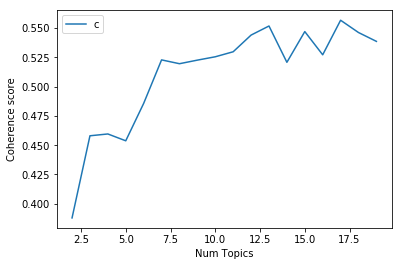

In [15]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### LDA with optimum_topic_count =17

In [38]:
lda_model_opt, perplexity_opt= identify_topics_lda_gensim(corpus_for_lda,8)

# Print the Keyword in the topics
print(lda_model_opt.print_topics())


# Compute Perplexity
print('\nPerplexity: ', perplexity_opt)  # a measure of how good the model is. lower the better.


C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda2\envs\myenv_3.5\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.s

[(0, '0.115*"page" + 0.071*"word" + 0.041*"save" + 0.037*"not" + 0.037*"can" + 0.037*"change" + 0.035*"firefox" + 0.034*"mozilla" + 0.027*"open" + 0.026*"share"'), (1, '0.208*"office" + 0.112*"ms" + 0.062*"message" + 0.060*"error" + 0.055*"file" + 0.054*"receive" + 0.025*"document" + 0.024*"excel" + 0.021*"powerpoint" + 0.019*"public"'), (2, '0.100*"delete" + 0.065*"folder" + 0.049*"explorer" + 0.049*"internet" + 0.047*"select" + 0.022*"bookmark" + 0.020*"copy" + 0.020*"file" + 0.019*"toolbar" + 0.018*"rename"'), (3, '0.157*"online" + 0.156*"ms" + 0.055*"create" + 0.050*"excel" + 0.036*"sharepoint" + 0.028*"access" + 0.024*"item" + 0.019*"send" + 0.016*"workbook" + 0.016*"column"'), (4, '0.125*"ms" + 0.117*"powerpoint" + 0.079*"change" + 0.040*"new" + 0.038*"slide" + 0.038*"presentation" + 0.037*"use" + 0.022*"remove" + 0.013*"window" + 0.012*"clipboard"'), (5, '0.105*"microsoft" + 0.077*"outlook" + 0.061*"sway" + 0.039*"ms" + 0.024*"card" + 0.024*"docs_com" + 0.021*"pane" + 0.020*"con

### Visualize LDA with optimum_topic_count =17

In [39]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_opt, corpus_for_lda, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.086796  0.136790       1        1  20.278545
1     -0.065228  0.212733       2        1  19.670929
6     -0.348074 -0.166849       3        1  16.345789
5      0.089669 -0.036676       4        1  11.233247
4     -0.010100 -0.013705       5        1  11.225059
0      0.198495 -0.154602       6        1   9.911005
7      0.060980  0.020804       7        1   5.826491
2      0.161054  0.001505       8        1   5.508936, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
315   Default  139.000000       office  139.000000  30.0000  30.0000
272   Default  108.000000       online  108.000000  29.0000  29.0000
527   Default   82.000000    publisher   82.000000  28.0000  28.0000
240   Default   63.000000       insert   63.000000  27.0000  27.0000
268   Default   59.000000        image   59.000000  26.0000  26.0000
269   Default   59.000000      picture   59.000000  25.0000  25.0000
30    Default   57.000000       search   57.000000  24.0000  24.0000
267   Default   55.000000         bing   55.000000  23.0000  23.0000
361   Default   63.000000   powerpoint   63.000000  22.0000  22.0000
2     Default   39.000000         page   39.000000  21.0000  21.0000
278   Default   50.000000    microsoft   50.000000  20.0000  20.0000
208   Default  341.000000           ms  341.000000  19.0000  19.0000
7     Default   48.000000       change   48.000000  18.0000  18.0000
467   Default   30.000000      outlook   30.000000  17.0000  17.0000
27    Default   22.000000         text   22.000000  16.0000  16.0000
35    Default   42.000000      message   42.000000  15.0000  15.0000
34    Default   40.000000        error   40.000000  14.0000  14.0000
53    Default   19.000000       delete   19.000000  13.0000  13.0000
10    Default   38.000000       create   38.000000  12.0000  12.0000
170   Default   24.000000         word   24.000000  11.0000  11.0000
47    Default   41.000000         file   41.000000  10.0000  10.0000
37    Default   36.000000      receive   36.000000   9.0000   9.0000
412   Default   23.000000         sway   23.000000   8.0000   8.0000
46    Default   12.000000       folder   12.000000   7.0000   7.0000
239   Default   57.000000        excel   57.000000   6.0000   6.0000
229   Default   25.000000   sharepoint   25.000000   5.0000   5.0000
179   Default   11.000000         show   11.000000   4.0000   4.0000
41    Default   16.000000          new   16.000000   3.0000   3.0000
183   Default   14.000000         save   14.000000   2.0000   2.0000
109   Default   15.000000        slide   15.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
32     Topic8    8.807273       select    9.700349   2.8022  -3.0495
40     Topic8    4.052328     bookmark    4.945039   2.6997  -3.8258
45     Topic8    3.582922      toolbar    4.475748   2.6763  -3.9489
49     Topic8    3.332980       rename    4.226089   2.6614  -4.0212
44     Topic8    2.791812     favorite    3.684782   2.6213  -4.1984
51     Topic8    2.155857       source    3.049106   2.5521  -4.4569
360    Topic8    1.967273         wrap    2.861524   2.5241  -4.5484
439    Topic8    1.887533      account    2.781288   2.5112  -4.5898
134    Topic8    1.786462       center    2.680562   2.4930  -4.6448
106    Topic8    1.721723         turn    2.614768   2.4809  -4.6817
103    Topic8    1.721181        crash    2.614743   2.4806  -4.6820
50     Topic8    1.673866  destination    2.567090   2.4712  -4.7099
567    Topic8    1.317144      forward    2.210315   2.3811  -4.9496
566    Topic8    1.317144        bring    2.210315   2.3811  -4.9496
542    Topic8    1.317144    disappear    2.210316   2.3811  -4.9496
543    Topic8    1.317144       ribbon    2.210316   2.3811  -4.9496
520    Topic8    1.317153     transf